In [1]:
# Forex Currency Prediction - Data Analysis & Modeling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model persistence
import joblib
import pickle
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [9]:
# STEP 1: DATA LOADING AND PREPROCESSING
def load_and_preprocess_data():
    """Load and preprocess the forex data"""
    # Load the Excel file
    df = pd.read_csv('Foreign_Exchange_Rates.xls')
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Rename the time column
    if 'Time Serie' in df.columns:
        df = df.rename(columns={'Time Serie': 'Date'})
    elif 'Unnamed: 1' in df.columns:
        df = df.rename(columns={'Unnamed: 1': 'Date'})
    
    # Drop the first column if it's just an index
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Drop rows with invalid dates
    df = df.dropna(subset=['Date'])
    
    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Create a mapping for cleaner currency names
    currency_mapping = {
        'AUSTRALIA - AUSTRALIAN DOLLAR/US$': 'AUD_USD',
        'EURO AREA - EURO/US$': 'EUR_USD', 
        'NEW ZEALAND - NEW ZELAND DOLLAR/US$': 'NZD_USD',
        'UNITED KINGDOM - UNITED KINGDOM POUND/US$': 'GBP_USD',
        'BRAZIL - REAL/US$': 'BRL_USD',
        'CANADA - CANADIAN DOLLAR/US$': 'CAD_USD',
        'CHINA - YUAN/US$': 'CNY_USD',
        'HONG KONG - HONG KONG DOLLAR/US$': 'HKD_USD',
        'INDIA - INDIAN RUPEE/US$': 'INR_USD',
        'KOREA - WON/US$': 'KRW_USD',
        'MEXICO - MEXICAN PESO/US$': 'MXN_USD',
        'SOUTH AFRICA - RAND/US$': 'ZAR_USD',
        'SINGAPORE - SINGAPORE DOLLAR/US$': 'SGD_USD',
        'DENMARK - DANISH KRONE/US$': 'DKK_USD',
        'JAPAN - YEN/US$': 'JPY_USD',
        'MALAYSIA - RINGGIT/US$': 'MYR_USD',
        'NORWAY - NORWEGIAN KRONE/US$': 'NOK_USD',
        'SWEDEN - KRONA/US$': 'SEK_USD',
        'SRI LANKA - SRI LANKAN RUPEE/US$': 'LKR_USD',
        'SWITZERLAND - FRANC/US$': 'CHF_USD',
        'TAIWAN - NEW TAIWAN DOLLAR/US$': 'TWD_USD',
        'THAILAND - BAHT/US$': 'THB_USD'
    }
    
    # Rename columns
    df = df.rename(columns=currency_mapping)
    
    # Get currency columns (all except Date)
    currency_cols = [col for col in df.columns if col != 'Date']
    
    # Convert currency columns to numeric
    for col in currency_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Handle missing values with forward fill
    df[currency_cols] = df[currency_cols].fillna(method='ffill')
    df[currency_cols] = df[currency_cols].fillna(method='bfill')
    
    return df, currency_cols

# Load the data
df, currency_cols = load_and_preprocess_data()

print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of currencies: {len(currency_cols)}")
print("\nFirst few rows:")
print(df.head())

Data shape: (2056, 24)
Date range: 2000-01-02 00:00:00 to 2019-12-12 00:00:00
Number of currencies: 23

First few rows:
        Date  AUD_USD  EUR_USD  NZD_USD  GBP_USD  BRL_USD  CAD_USD  CNY_USD  \
0 2000-01-02   1.5835   1.0276   2.0392   0.6192    1.795   1.4468   8.2774   
1 2000-01-03   1.6483   1.0309   2.0606   0.6310    1.769   1.4470   8.2786   
2 2000-01-05   1.7241   1.0965   2.0683   0.6428    1.807   1.4783   8.2799   
3 2000-01-06   1.7479   1.0745   2.1925   0.6705    1.821   1.4910   8.2771   
4 2000-01-08   1.7227   1.0837   2.1997   0.6670    1.786   1.4892   8.2788   

   HKD_USD  INR_USD  ...  DKK_USD  JPY_USD  MYR_USD  NOK_USD  SEK_USD  \
0   7.7807    43.62  ...   7.6445   107.67      3.8   8.2770   8.7680   
1   7.7824    43.63  ...   7.6730   107.10      3.8   8.3115   8.6865   
2   7.7890    43.67  ...   8.1695   108.89      3.8   8.9050   8.9183   
3   7.7920    44.65  ...   8.0225   108.74      3.8   8.9400   8.9680   
4   7.7993    45.15  ...   8.0840   109.

In [10]:
# STEP 2: EXPLORATORY DATA ANALYSIS
def perform_eda(df, currency_cols):
    """Perform comprehensive EDA"""
    
    # Basic statistics
    print("Basic Statistics:")
    print(df[currency_cols].describe())
    
    # Missing values
    print("\nMissing Values:")
    print(df.isnull().sum())

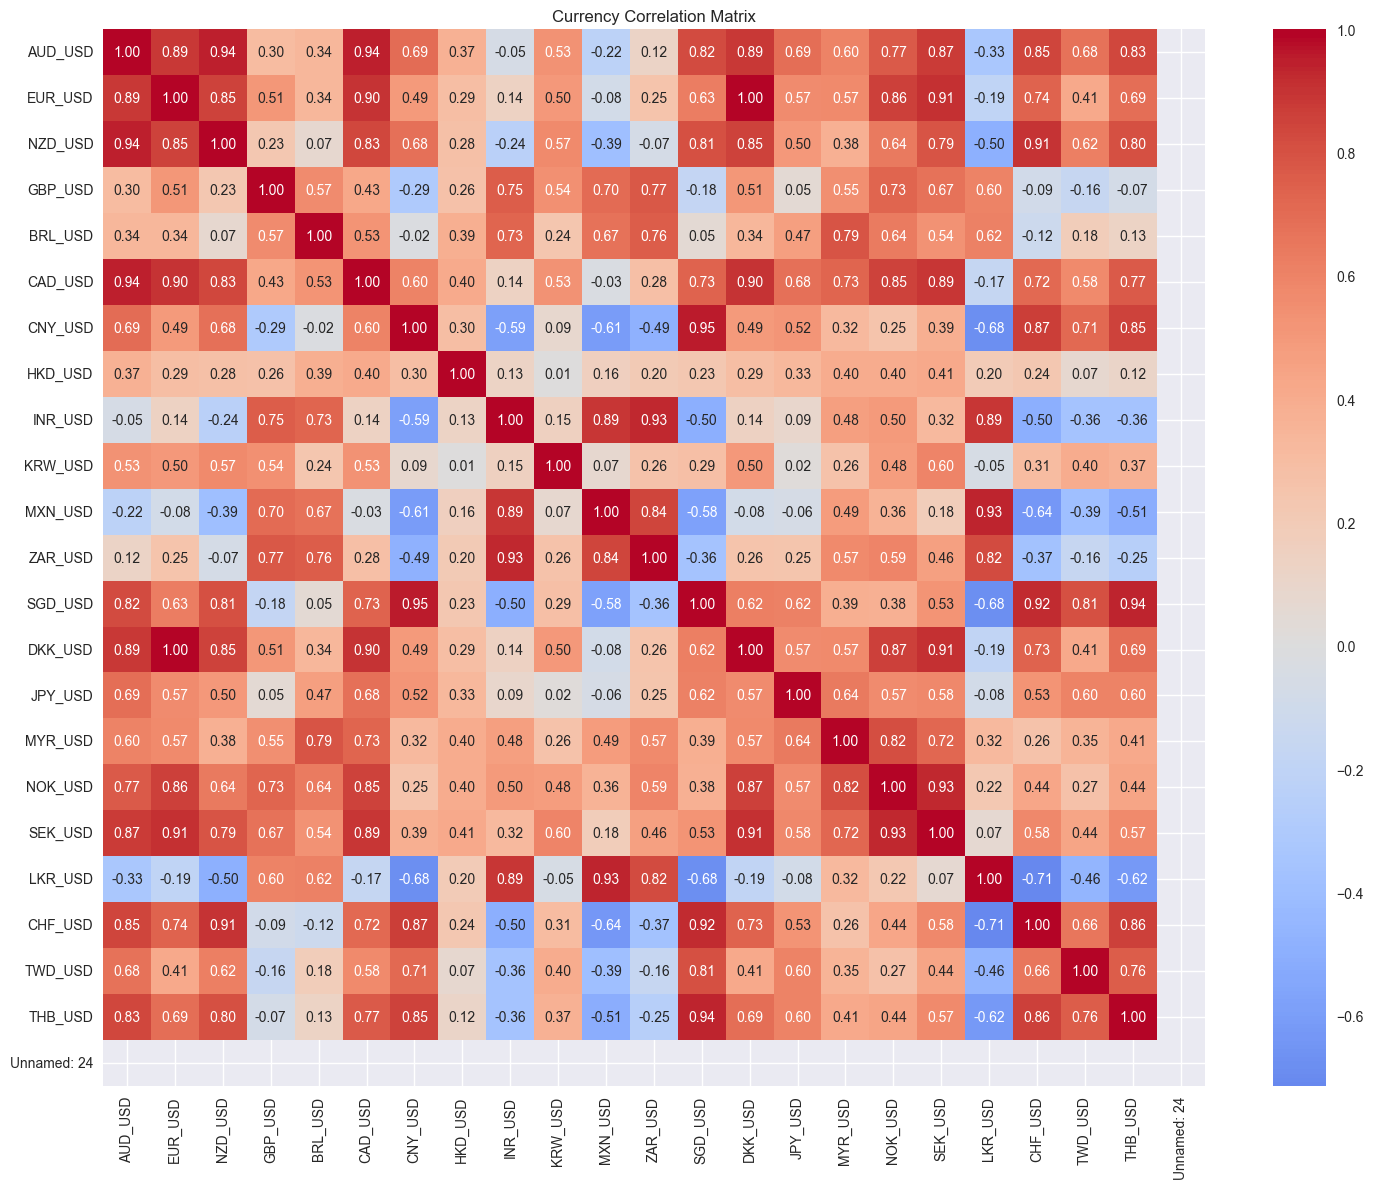

In [12]:
# Correlation matrix
plt.figure(figsize=(15, 12))
correlation_matrix = df[currency_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Currency Correlation Matrix')
plt.tight_layout()
plt.show()

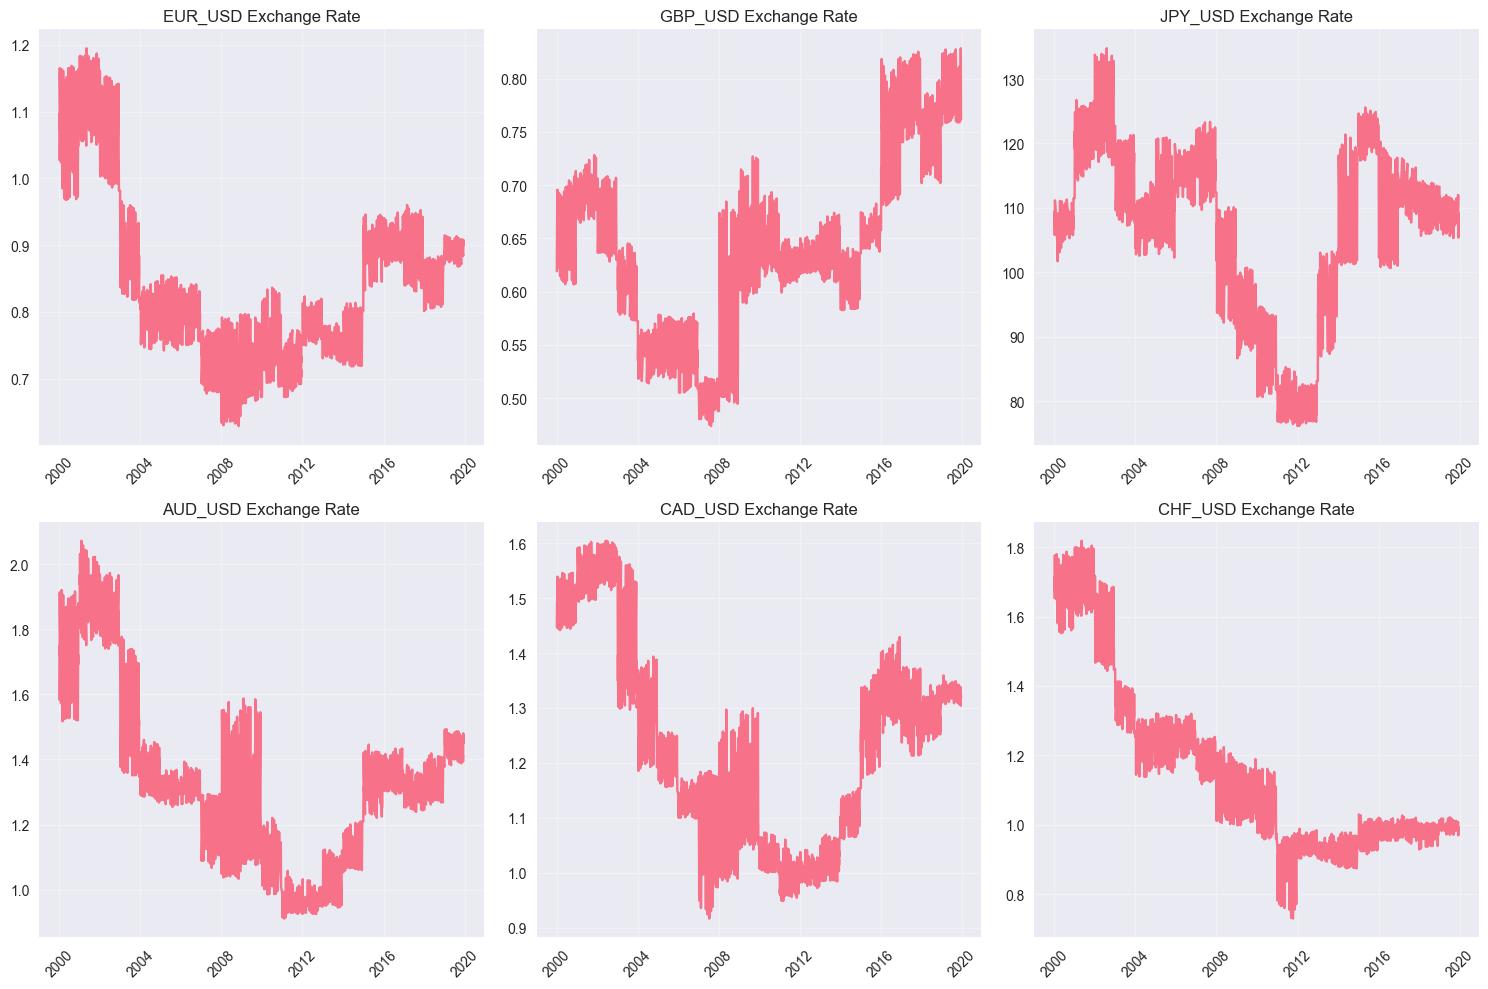

In [14]:
 # Time series plots for major currencies
major_currencies = ['EUR_USD', 'GBP_USD', 'JPY_USD', 'AUD_USD', 'CAD_USD', 'CHF_USD']
available_major = [curr for curr in major_currencies if curr in currency_cols]
    
if available_major:
    plt.figure(figsize=(15, 10))
    for i, currency in enumerate(available_major[:6], 1):
            plt.subplot(2, 3, i)
            plt.plot(df['Date'], df[currency])
            plt.title(f'{currency} Exchange Rate')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Creating returns analysis...


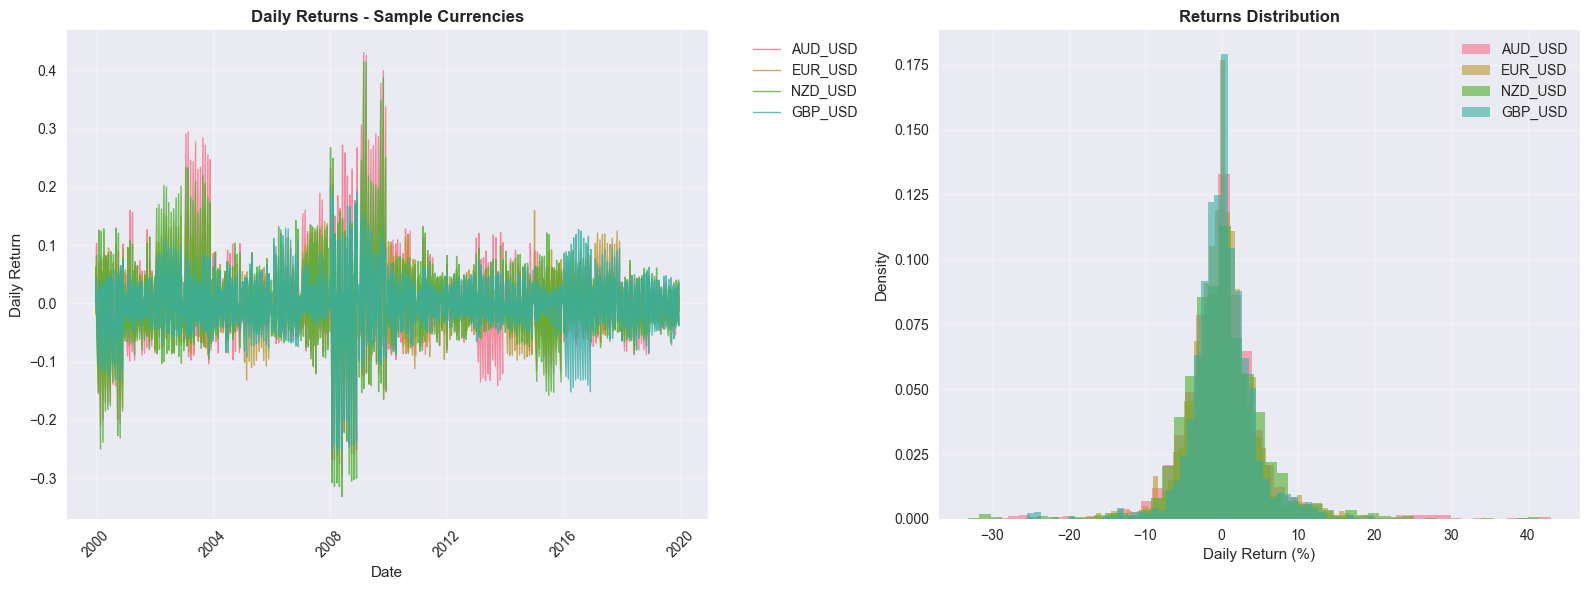

✅ Returns analysis completed successfully!
Returns analysis section complete!


In [16]:
# Returns analysis
print("Creating returns analysis...")
returns_df = df.copy()

# Calculate returns for each currency
for currency in currency_cols:
    returns_df[f'{currency}_return'] = df[currency].pct_change()

# Get return columns
return_cols = [col for col in returns_df.columns if '_return' in col]

# Only create plots if we have return data
if return_cols and len(return_cols) > 0:
    # Create the returns plot with proper error handling
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Daily returns time series (first 4 currencies)
        sample_returns = return_cols[:4]
        for i, col in enumerate(sample_returns):
            ax1.plot(returns_df['Date'], returns_df[col], 
                    linewidth=1, alpha=0.8, label=col.replace('_return', ''))
        
        ax1.set_title('Daily Returns - Sample Currencies', fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Daily Return')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Returns distribution histograms
        for i, col in enumerate(sample_returns):
            returns_data = returns_df[col].dropna()
            if len(returns_data) > 0:
                ax2.hist(returns_data * 100, bins=50, alpha=0.6, 
                        label=col.replace('_return', ''), density=True)
        
        ax2.set_title('Returns Distribution', fontweight='bold')
        ax2.set_xlabel('Daily Return (%)')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Returns analysis completed successfully!")
        
    except Exception as e:
        print(f"⚠️ Could not create returns plots: {e}")
        print("Continuing without returns visualization...")

else:
    print("⚠️ No return data available, skipping returns analysis")

# Continue with the rest of your analysis...
print("Returns analysis section complete!")

In [17]:
returns_df = perform_eda(df, currency_cols)

Basic Statistics:
           AUD_USD      EUR_USD      NZD_USD      GBP_USD      BRL_USD  \
count  2056.000000  2056.000000  2056.000000  2056.000000  2056.000000   
mean      1.331495     0.843733     1.543798     0.640374     2.543583   
std       0.269330     0.126314     0.336664     0.082575     0.721265   
min       0.911600     0.629000     1.134600     0.473800     1.554300   
25%       1.110850     0.751350     1.320650     0.588500     1.942825   
50%       1.309250     0.815300     1.445900     0.636600     2.314550   
75%       1.428700     0.899950     1.588600     0.691200     3.124550   
max       2.071300     1.194700     2.536800     0.828500     4.220000   

           CAD_USD      CNY_USD      HKD_USD      INR_USD      KRW_USD  ...  \
count  2056.000000  2056.000000  2056.000000  2056.000000  2056.000000  ...   
mean      1.230001     7.198945     7.782455    52.676083  1125.074912  ...   
std       0.182161     0.821144     0.027783     9.670695   103.960751  ...   

In [18]:
# STEP 3: FEATURE ENGINEERING
def create_features(df, currency):
    """Create features for time series modeling"""
    data = df[['Date', currency]].copy()
    data = data.dropna()
    
    # Technical indicators
    data['MA_7'] = data[currency].rolling(window=7).mean()
    data['MA_30'] = data[currency].rolling(window=30).mean()
    data['MA_90'] = data[currency].rolling(window=90).mean()
    
    # Volatility
    data['volatility_7'] = data[currency].rolling(window=7).std()
    data['volatility_30'] = data[currency].rolling(window=30).std()
    
    # Price changes
    data['price_change_1'] = data[currency].diff(1)
    data['price_change_7'] = data[currency].diff(7)
    data['price_change_30'] = data[currency].diff(30)
    
    # Returns
    data['return_1'] = data[currency].pct_change(1)
    data['return_7'] = data[currency].pct_change(7)
    data['return_30'] = data[currency].pct_change(30)
    
    # Momentum indicators
    data['momentum_14'] = data[currency] / data[currency].shift(14) - 1
    
    # Date features
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['dayofweek'] = data['Date'].dt.dayofweek
    data['quarter'] = data['Date'].dt.quarter
    
    # Lag features
    for lag in [1, 2, 3, 7, 14, 30]:
        data[f'lag_{lag}'] = data[currency].shift(lag)
    
    # Drop rows with NaN values
    data = data.dropna()
    
    return data

In [19]:
# STEP 4: MODEL BUILDING FUNCTIONS
def prepare_data_for_ml(data, currency, test_days=60):
    """Prepare data for machine learning models"""
    # Split the data
    train_size = len(data) - test_days
    train_data = data[:train_size].copy()
    test_data = data[train_size:].copy()
    
    # Feature columns (excluding Date and target)
    feature_cols = [col for col in data.columns if col not in ['Date', currency]]
    
    X_train = train_data[feature_cols]
    y_train = train_data[currency]
    X_test = test_data[feature_cols]
    y_test = test_data[currency]
    
    return X_train, X_test, y_train, y_test, train_data, test_data

def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def train_xgboost_model(X_train, X_test, y_train, y_test):
    """Train XGBoost model"""
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              early_stopping_rounds=100, 
              verbose=False)
    
    y_pred = model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    
    return model, y_pred, metrics

def train_lightgbm_model(X_train, X_test, y_train, y_test):
    """Train LightGBM model"""
    model = lgb.LGBMRegressor(
        n_estimators=1000,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1
    )
    
    model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              early_stopping_rounds=100, 
              verbose=False)
    
    y_pred = model.predict(X_test)
    metrics = calculate_metrics(y_test, y_pred)
    
    return model, y_pred, metrics

def train_lstm_model(data, currency, test_days=60, lookback=30):
    """Train LSTM model"""
    # Prepare data for LSTM
    values = data[currency].values.reshape(-1, 1)
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(values)
    
    # Create sequences
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)
    
    X, y = create_sequences(scaled_values, lookback)
    
    # Split the data
    train_size = len(X) - test_days
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train the model
    history = model.fit(X_train, y_train, batch_size=32, epochs=100, 
                       validation_data=(X_test, y_test), verbose=0)
    
    # Make predictions
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Inverse transform predictions
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    metrics = calculate_metrics(y_test_actual, y_pred)
    
    return model, y_pred, metrics, scaler

def train_prophet_model(data, currency, test_days=60):
    """Train Prophet model"""
    # Prepare data for Prophet
    prophet_data = data[['Date', currency]].copy()
    prophet_data.columns = ['ds', 'y']
    
    # Split the data
    train_size = len(prophet_data) - test_days
    train_data = prophet_data[:train_size]
    test_data = prophet_data[train_size:]
    
    # Train Prophet model
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    
    model.fit(train_data)
    
    # Make predictions
    future = model.make_future_dataframe(periods=test_days)
    forecast = model.predict(future)
    
    # Get test predictions
    y_pred = forecast.tail(test_days)['yhat'].values
    y_test = test_data['y'].values
    
    metrics = calculate_metrics(y_test, y_pred)
    
    return model, y_pred, metrics

def train_arima_model(data, currency, test_days=60):
    """Train ARIMA model"""
    values = data[currency].values
    
    # Split the data
    train_size = len(values) - test_days
    train_data = values[:train_size]
    test_data = values[train_size:]
    
    try:
        # Fit ARIMA model (using auto order selection would be better in practice)
        model = ARIMA(train_data, order=(1, 1, 1))
        fitted_model = model.fit()
        
        # Make predictions
        y_pred = fitted_model.forecast(steps=test_days)
        
        metrics = calculate_metrics(test_data, y_pred)
        
        return fitted_model, y_pred, metrics
    except:
        print(f"ARIMA failed for {currency}")
        return None, None, None

In [20]:
# STEP 5: MODEL COMPARISON AND SELECTION
def compare_models_for_currency(df, currency, test_days=60):
    """Compare all models for a specific currency"""
    print(f"\n{'='*60}")
    print(f"TRAINING MODELS FOR {currency}")
    print(f"{'='*60}")
    
    # Create features
    data = create_features(df, currency)
    print(f"Created features. Data shape: {data.shape}")
    
    results = {}
    models = {}
    
    # Prepare ML data
    X_train, X_test, y_train, y_test, train_data, test_data = prepare_data_for_ml(data, currency, test_days)
    
    # 1. XGBoost
    try:
        print("Training XGBoost...")
        xgb_model, xgb_pred, xgb_metrics = train_xgboost_model(X_train, X_test, y_train, y_test)
        results['XGBoost'] = xgb_metrics
        models['XGBoost'] = xgb_model
        print(f"XGBoost - MAE: {xgb_metrics['MAE']:.4f}, RMSE: {xgb_metrics['RMSE']:.4f}, MAPE: {xgb_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"XGBoost failed: {e}")
    
    # 2. LightGBM
    try:
        print("Training LightGBM...")
        lgb_model, lgb_pred, lgb_metrics = train_lightgbm_model(X_train, X_test, y_train, y_test)
        results['LightGBM'] = lgb_metrics
        models['LightGBM'] = lgb_model
        print(f"LightGBM - MAE: {lgb_metrics['MAE']:.4f}, RMSE: {lgb_metrics['RMSE']:.4f}, MAPE: {lgb_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"LightGBM failed: {e}")
    
    # 3. LSTM
    try:
        print("Training LSTM...")
        lstm_model, lstm_pred, lstm_metrics, lstm_scaler = train_lstm_model(data, currency, test_days)
        results['LSTM'] = lstm_metrics
        models['LSTM'] = {'model': lstm_model, 'scaler': lstm_scaler}
        print(f"LSTM - MAE: {lstm_metrics['MAE']:.4f}, RMSE: {lstm_metrics['RMSE']:.4f}, MAPE: {lstm_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"LSTM failed: {e}")
    
    # 4. Prophet
    try:
        print("Training Prophet...")
        prophet_model, prophet_pred, prophet_metrics = train_prophet_model(data, currency, test_days)
        results['Prophet'] = prophet_metrics
        models['Prophet'] = prophet_model
        print(f"Prophet - MAE: {prophet_metrics['MAE']:.4f}, RMSE: {prophet_metrics['RMSE']:.4f}, MAPE: {prophet_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"Prophet failed: {e}")
    
    # 5. ARIMA
    try:
        print("Training ARIMA...")
        arima_model, arima_pred, arima_metrics = train_arima_model(data, currency, test_days)
        if arima_model is not None:
            results['ARIMA'] = arima_metrics
            models['ARIMA'] = arima_model
            print(f"ARIMA - MAE: {arima_metrics['MAE']:.4f}, RMSE: {arima_metrics['RMSE']:.4f}, MAPE: {arima_metrics['MAPE']:.2f}%")
    except Exception as e:
        print(f"ARIMA failed: {e}")
    
    # Find best model based on RMSE
    if results:
        best_model_name = min(results.keys(), key=lambda x: results[x]['RMSE'])
        best_model = models[best_model_name]
        best_metrics = results[best_model_name]
        
        print(f"\nBEST MODEL for {currency}: {best_model_name}")
        print(f"Best metrics - MAE: {best_metrics['MAE']:.4f}, RMSE: {best_metrics['RMSE']:.4f}, MAPE: {best_metrics['MAPE']:.2f}%")
        
        return best_model_name, best_model, best_metrics, results
    else:
        print(f"No models succeeded for {currency}")
        return None, None, None, None

In [21]:
# STEP 6: TRAIN MODELS FOR ALL CURRENCIES
# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Train models for selected currencies (top 10 most liquid)
selected_currencies = ['EUR_USD', 'GBP_USD', 'JPY_USD', 'AUD_USD', 'CAD_USD', 
                      'CHF_USD', 'NZD_USD', 'CNY_USD', 'SGD_USD', 'NOK_USD']

# Filter to only currencies available in our dataset
available_currencies = [curr for curr in selected_currencies if curr in currency_cols]
if not available_currencies:
    available_currencies = currency_cols[:10]  # Take first 10 if our selected ones aren't available

print(f"Training models for currencies: {available_currencies}")

best_models = {}
all_results = {}

for currency in available_currencies[:5]:  # Limit to 5 currencies for demo
    try:
        best_name, best_model, best_metrics, results = compare_models_for_currency(df, currency)
        if best_model is not None:
            best_models[currency] = {
                'model_type': best_name,
                'model': best_model,
                'metrics': best_metrics
            }
            all_results[currency] = results
            
            # Save the best model
            model_filename = f'models/{currency}_model.pkl'
            with open(model_filename, 'wb') as f:
                pickle.dump(best_models[currency], f)
            print(f"Saved best model for {currency} to {model_filename}")
        
    except Exception as e:
        print(f"Failed to train models for {currency}: {e}")

Training models for currencies: ['EUR_USD', 'GBP_USD', 'JPY_USD', 'AUD_USD', 'CAD_USD', 'CHF_USD', 'NZD_USD', 'CNY_USD', 'SGD_USD', 'NOK_USD']

TRAINING MODELS FOR EUR_USD
Created features. Data shape: (1967, 25)
Training XGBoost...
XGBoost failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LightGBM...
LightGBM failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LSTM...
LSTM - MAE: 0.0111, RMSE: 0.0129, MAPE: 1.24%
Training Prophet...


14:20:40 - cmdstanpy - INFO - Chain [1] start processing
14:20:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 0.0311, RMSE: 0.0332, MAPE: 3.47%
Training ARIMA...
ARIMA - MAE: 0.0096, RMSE: 0.0114, MAPE: 1.08%

BEST MODEL for EUR_USD: ARIMA
Best metrics - MAE: 0.0096, RMSE: 0.0114, MAPE: 1.08%
Saved best model for EUR_USD to models/EUR_USD_model.pkl

TRAINING MODELS FOR GBP_USD
Created features. Data shape: (1967, 25)
Training XGBoost...
XGBoost failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LightGBM...
LightGBM failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LSTM...


14:21:15 - cmdstanpy - INFO - Chain [1] start processing


LSTM - MAE: 0.0124, RMSE: 0.0156, MAPE: 1.59%
Training Prophet...


14:21:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 0.0238, RMSE: 0.0269, MAPE: 3.07%
Training ARIMA...
ARIMA - MAE: 0.0169, RMSE: 0.0208, MAPE: 2.13%

BEST MODEL for GBP_USD: LSTM
Best metrics - MAE: 0.0124, RMSE: 0.0156, MAPE: 1.59%
Saved best model for GBP_USD to models/GBP_USD_model.pkl

TRAINING MODELS FOR JPY_USD
Created features. Data shape: (1967, 25)
Training XGBoost...
XGBoost failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LightGBM...
LightGBM failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LSTM...


14:21:50 - cmdstanpy - INFO - Chain [1] start processing


LSTM - MAE: 1.0845, RMSE: 1.3851, MAPE: 1.00%
Training Prophet...


14:21:50 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 1.3734, RMSE: 1.7683, MAPE: 1.25%
Training ARIMA...
ARIMA - MAE: 1.2387, RMSE: 1.6219, MAPE: 1.14%

BEST MODEL for JPY_USD: LSTM
Best metrics - MAE: 1.0845, RMSE: 1.3851, MAPE: 1.00%
Saved best model for JPY_USD to models/JPY_USD_model.pkl

TRAINING MODELS FOR AUD_USD
Created features. Data shape: (1967, 25)
Training XGBoost...
XGBoost failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LightGBM...
LightGBM failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LSTM...


14:22:25 - cmdstanpy - INFO - Chain [1] start processing


LSTM - MAE: 0.0174, RMSE: 0.0209, MAPE: 1.21%
Training Prophet...


14:22:25 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 0.0566, RMSE: 0.0637, MAPE: 3.90%
Training ARIMA...
ARIMA - MAE: 0.0753, RMSE: 0.0856, MAPE: 5.20%

BEST MODEL for AUD_USD: LSTM
Best metrics - MAE: 0.0174, RMSE: 0.0209, MAPE: 1.21%
Saved best model for AUD_USD to models/AUD_USD_model.pkl

TRAINING MODELS FOR CAD_USD
Created features. Data shape: (1967, 25)
Training XGBoost...
XGBoost failed: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LightGBM...
LightGBM failed: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'
Training LSTM...


14:23:01 - cmdstanpy - INFO - Chain [1] start processing


LSTM - MAE: 0.0083, RMSE: 0.0104, MAPE: 0.63%
Training Prophet...


14:23:01 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MAE: 0.0154, RMSE: 0.0181, MAPE: 1.16%
Training ARIMA...
ARIMA - MAE: 0.0083, RMSE: 0.0106, MAPE: 0.62%

BEST MODEL for CAD_USD: LSTM
Best metrics - MAE: 0.0083, RMSE: 0.0104, MAPE: 0.63%
Saved best model for CAD_USD to models/CAD_USD_model.pkl



FINAL RESULTS SUMMARY
Currency Best_Model      MAE     RMSE     MAPE
 EUR_USD      ARIMA 0.009636 0.011411 1.081831
 GBP_USD       LSTM 0.012409 0.015575 1.585879
 JPY_USD       LSTM 1.084476 1.385144 1.002369
 AUD_USD       LSTM 0.017429 0.020918 1.212332
 CAD_USD       LSTM 0.008317 0.010427 0.625292


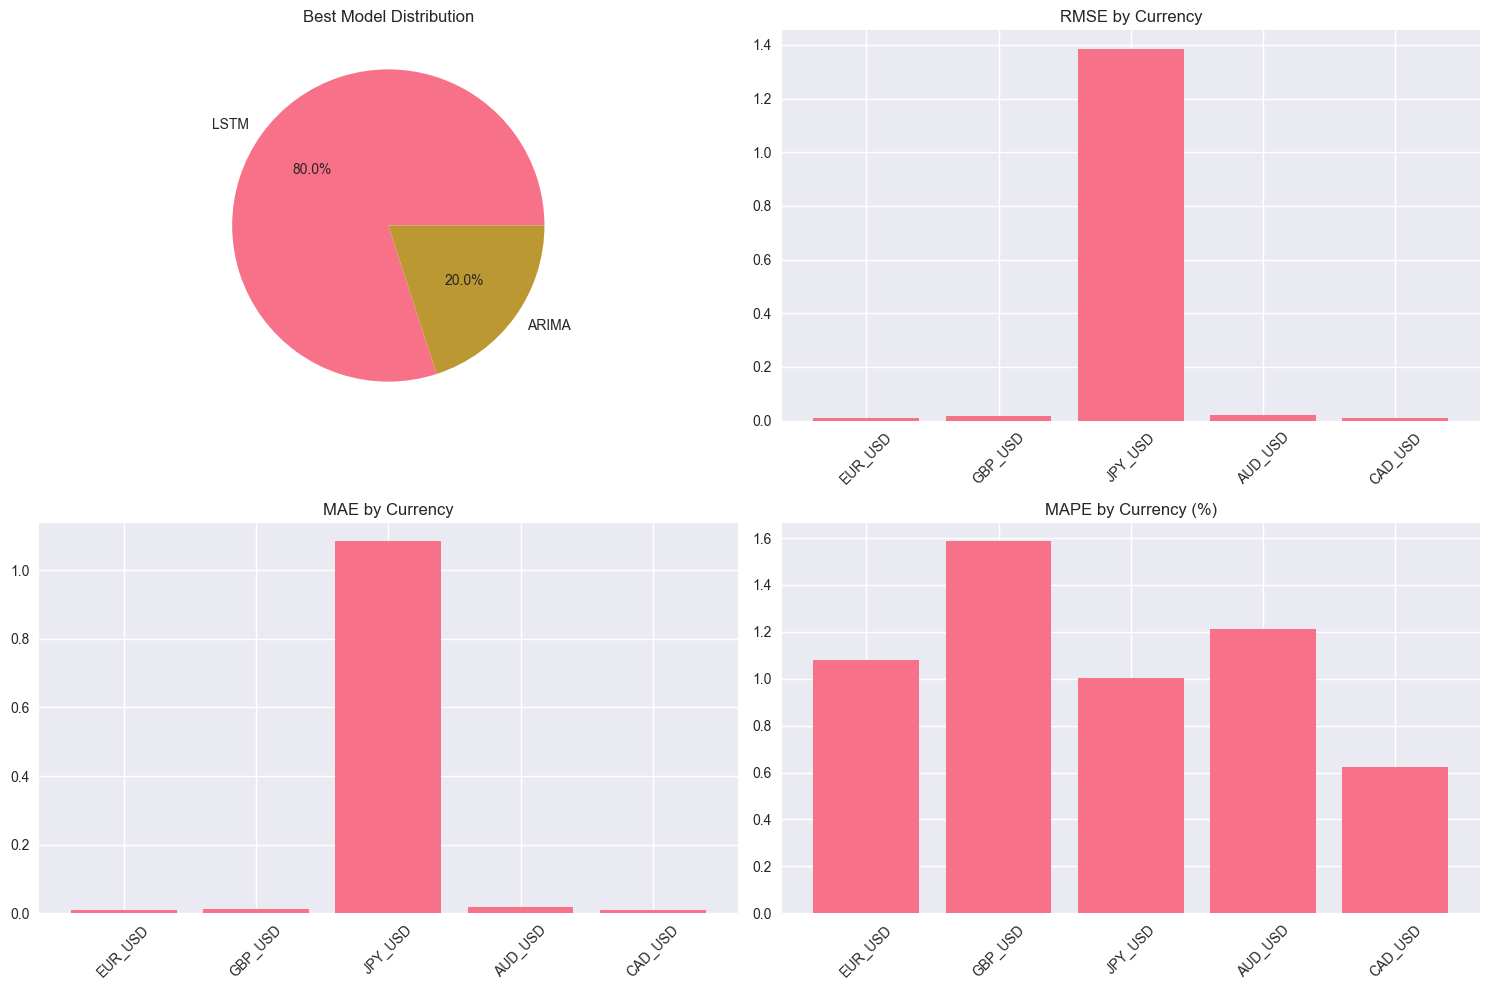


Models saved in 'models/' directory
Ready to build Streamlit app!
Metadata saved for Streamlit app!


In [22]:
# STEP 7: RESULTS SUMMARY
print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*80}")

if best_models:
    # Create results summary DataFrame
    summary_data = []
    for currency, model_info in best_models.items():
        summary_data.append({
            'Currency': currency,
            'Best_Model': model_info['model_type'],
            'MAE': model_info['metrics']['MAE'],
            'RMSE': model_info['metrics']['RMSE'],
            'MAPE': model_info['metrics']['MAPE']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Visualize results
    if len(summary_df) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Model distribution
        model_counts = summary_df['Best_Model'].value_counts()
        axes[0,0].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
        axes[0,0].set_title('Best Model Distribution')
        
        # RMSE comparison
        axes[0,1].bar(summary_df['Currency'], summary_df['RMSE'])
        axes[0,1].set_title('RMSE by Currency')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # MAE comparison
        axes[1,0].bar(summary_df['Currency'], summary_df['MAE'])
        axes[1,0].set_title('MAE by Currency')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # MAPE comparison
        axes[1,1].bar(summary_df['Currency'], summary_df['MAPE'])
        axes[1,1].set_title('MAPE by Currency (%)')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

print(f"\nModels saved in 'models/' directory")
print(f"Ready to build Streamlit app!")

# Save currency list and other metadata for the app
metadata = {
    'currencies': list(best_models.keys()) if best_models else available_currencies,
    'date_range': [df['Date'].min().strftime('%Y-%m-%d'), df['Date'].max().strftime('%Y-%m-%d')],
    'total_records': len(df)
}

with open('models/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Metadata saved for Streamlit app!")